In [1]:
import os
import pickle
%matplotlib inline
import pandas as pd
import seaborn as sns
from tqdm import tqdm

In [2]:
nodes = pd.read_csv('../data/nodes.csv')
edges = pd.read_csv('../data/edges.csv')

# remove : character from column names to make them queryabke
nodes.columns = ['ID', 'name', 'LABEL']
edges.columns = ['START_ID', 'END_ID', 'TYPE']

In [3]:
comps = (nodes['LABEL'] == 'Compound').sum() 
diseases = (nodes['LABEL'] == 'Disease').sum()

print('{:,} Compounds x {:,} Diseases = {:,} C-D pairs'.format(comps, diseases, comps*diseases))

20,196 Compounds x 4,943 Diseases = 99,828,828 C-D pairs


In [4]:
nodes.head()

,ID,name,LABEL
0,C0150210,Physiological energy management,Activities & Behaviors
1,C1512265,Grant Review Process,Activities & Behaviors
2,C0683830,document management,Activities & Behaviors
3,C0260207,Rest periods,Activities & Behaviors
4,C0871414,Sperm donation,Activities & Behaviors


In [5]:
edges.head()

,START_ID,END_ID,TYPE
0,C1273870,C0282623,ADMINISTERED_TO_ABatAB
1,C0441648,C0221192,ADMINISTERED_TO_ABatCI
2,C1273870,C1138603,ADMINISTERED_TO_ABatCI
3,C0556656,C0221192,ADMINISTERED_TO_ABatCI
4,C0935546,C0221192,ADMINISTERED_TO_ABatCI


In [6]:
print(edges.shape[0])
edges = edges.drop_duplicates()
edges = edges.dropna()
edges.shape

20521816


(20521816, 3)

In [7]:
counts = edges["TYPE"].value_counts()
counts

INTERACTS_WITH_CDiwCD           828685
LOCATION_OF_AloCD               800579
STIMULATES_CDstCD               452324
COEXISTS_WITH_CDcwCD            450955
INTERACTS_WITH_GiwCD            424928
LOCATION_OF_AloG                419681
PROCESS_OF_DOpro>LB             410679
INHIBITS_CDinCD                 379340
LOCATION_OF_AloDO               366582
LOCATION_OF_LBloCD              352224
AFFECTS_CDafPS                  351362
PART_OF_CDpo>A                  317538
STIMULATES_GstCD                317084
TREATS_CDtDO                    310916
TREATS_PRtDO                    292562
USES_PRuCD                      278386
COEXISTS_WITH_DOcwDO            259293
COEXISTS_WITH_CDcwG             255227
COEXISTS_WITH_DOcwD             243032
PART_OF_Gpo>A                   234502
INHIBITS_CDinG                  227114
ASSOCIATED_WITH_CDawDO          217893
PART_OF_Apo>A                   202994
CAUSES_CDcDO                    202497
PART_OF_CDpo>LB                 193324
compared_with_CDcpwCD    

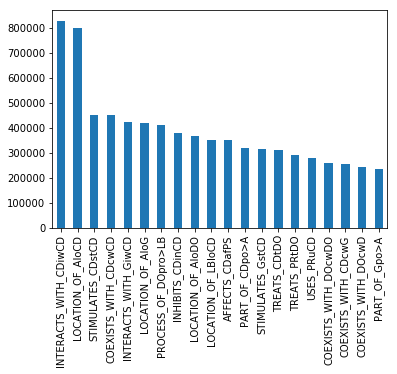

In [8]:
counts[:20].plot(kind='bar');

Several relationships with low counts, A->B and B->A relationships could potentially be combined into A-B relationships

# Filter out the lower count edge types

In [9]:
'{:,}'.format(edges.shape[0])

'20,521,816'

In [10]:
cutoff = .001

print("Number of edge types with this cutoff: {}".format((counts > cutoff*len(edges)).sum()))
print("Number of edges that remain with this cutoff: {:,}".format(counts[counts > cutoff*len(edges)].sum()))

Number of edge types with this cutoff: 155
Number of edges that remain with this cutoff: 17,666,666


In [11]:
ok_edges = list(counts[counts > cutoff*len(edges)].index)

In [12]:
result = edges.query('TYPE in @ok_edges')

In [13]:
'{:,}'.format(result.shape[0])

'17,666,666'

# Some quick validation that all ids are the same between nodes and edges

In [14]:
edge_ids = set(result['START_ID'].unique()).union(set(result['END_ID'].unique()))

In [15]:
node_ids = set(nodes['ID'].unique())

In [16]:
not_in_edges = node_ids - edge_ids

In [17]:
not_in_edges = list(not_in_edges)

In [18]:
idx = nodes.query('ID in @not_in_edges').index
nodes.loc[idx]

,ID,name,LABEL
1,C1512265,Grant Review Process,Activities & Behaviors
2,C0683830,document management,Activities & Behaviors
3,C0260207,Rest periods,Activities & Behaviors
7,C0023679,Life Table Analysis,Activities & Behaviors
14,C0237821,Military Recruitment,Activities & Behaviors
15,C0522727,Sailing,Activities & Behaviors
16,C0681649,high school sports,Activities & Behaviors
19,C0815198,social life,Activities & Behaviors
22,C0038123,Staff Development,Activities & Behaviors
23,C0178534,Careers,Activities & Behaviors


In [19]:
nodes = nodes.drop(idx)

In [20]:
len(nodes)

253006

In [21]:
# Sort values before writing to disk
result = result.sort_values('TYPE')
nodes = nodes.sort_values('LABEL')

# Add in colons required by neo4j
result.columns = [':START_ID', ':END_ID', ':TYPE']
nodes.columns = [':ID', 'name', ':LABEL']

result.to_csv('../data/edges_filtered_001.csv', index=False)
nodes.to_csv('../data/nodes_filtered_001.csv', index=False)

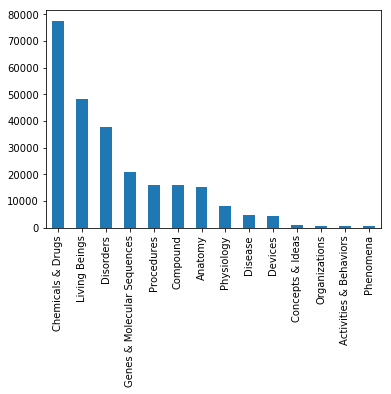

In [22]:
nodes[':LABEL'].value_counts().plot(kind='bar');

# Look at the Metagraph to see if some edges can be combined

In [23]:
# Make the columns queryable and easier to work with
nodes.columns = ['ID', 'name', 'LABEL']
result.columns = ['START_ID', 'END_ID', 'TYPE']

In [24]:
def list_connections(metanode1, metanode2):
    
    # get the ids for the given node
    ids1 = list(nodes.query("LABEL == @metanode1")['ID'])
    
    # if looking at edges between the same metanode, can get result right away
    if metanode1 == metanode2:
        res = result.query('START_ID in @ids1 and END_ID in @ids1')
    
    else:
        # Ids for second metanode
        ids2 = list(nodes.query("LABEL == @metanode2")['ID'])
    
        # 
        res1 = result.query('START_ID in @ids1 and END_ID in @ids2')
        res2 = result.query('START_ID in @ids2 and END_ID in @ids1')
    
        res = pd.concat([res1, res2])
    
    return res['TYPE'].value_counts()
    

In [25]:
id_to_type = nodes.set_index('ID')['LABEL'].to_dict()

In [26]:
combos = []
for row in result.drop_duplicates(subset='TYPE').itertuples(index=False):
    combos.append((id_to_type[row[0]], id_to_type[row[1]]))
combos = [tuple(sorted(c)) for c in combos]
combos = sorted(list(set(combos)))
len(combos)

47

In [27]:
combos

[('Activities & Behaviors', 'Living Beings'),
 ('Anatomy', 'Anatomy'),
 ('Anatomy', 'Chemicals & Drugs'),
 ('Anatomy', 'Compound'),
 ('Anatomy', 'Concepts & Ideas'),
 ('Anatomy', 'Devices'),
 ('Anatomy', 'Disease'),
 ('Anatomy', 'Disorders'),
 ('Anatomy', 'Genes & Molecular Sequences'),
 ('Anatomy', 'Living Beings'),
 ('Anatomy', 'Procedures'),
 ('Chemicals & Drugs', 'Chemicals & Drugs'),
 ('Chemicals & Drugs', 'Compound'),
 ('Chemicals & Drugs', 'Disease'),
 ('Chemicals & Drugs', 'Disorders'),
 ('Chemicals & Drugs', 'Genes & Molecular Sequences'),
 ('Chemicals & Drugs', 'Living Beings'),
 ('Chemicals & Drugs', 'Phenomena'),
 ('Chemicals & Drugs', 'Physiology'),
 ('Chemicals & Drugs', 'Procedures'),
 ('Compound', 'Genes & Molecular Sequences'),
 ('Compound', 'Living Beings'),
 ('Devices', 'Devices'),
 ('Devices', 'Disorders'),
 ('Devices', 'Procedures'),
 ('Disease', 'Disease'),
 ('Disease', 'Disorders'),
 ('Disease', 'Genes & Molecular Sequences'),
 ('Disease', 'Living Beings'),
 ('Di

In [28]:
if os.path.exists("../data/edge_pair_counts_orig.pkl"):
    combo_counts = pickle.load(open( "../data/edge_pair_counts_orig.pkl", "rb" ))
else:
    # This block took 138-minutes to run, pickleing for future use
    combo_counts = dict()
    for comb in tqdm(combos):
        combo_counts[comb] = list_connections(comb[0], comb[1])
    pickle.dump(combo_counts, open( "../data/edge_pair_counts_orig.pkl", "wb" ) )

100%|██████████| 47/47 [2:16:56<00:00, 145.61s/it]  


In [29]:
edge_numbs = {k: len(v) for k, v in combo_counts.items()}

In [30]:
most_to_least = sorted(list(edge_numbs.items()), key = lambda x: x[1], reverse=True)
for item in most_to_least:
    print(item[0], ':', item[1])

('Chemicals & Drugs', 'Chemicals & Drugs') : 11
('Chemicals & Drugs', 'Genes & Molecular Sequences') : 10
('Chemicals & Drugs', 'Disorders') : 9
('Disorders', 'Genes & Molecular Sequences') : 7
('Chemicals & Drugs', 'Disease') : 7
('Genes & Molecular Sequences', 'Genes & Molecular Sequences') : 7
('Anatomy', 'Chemicals & Drugs') : 6
('Anatomy', 'Genes & Molecular Sequences') : 6
('Chemicals & Drugs', 'Physiology') : 6
('Chemicals & Drugs', 'Compound') : 5
('Disorders', 'Disorders') : 5
('Disease', 'Genes & Molecular Sequences') : 5
('Disorders', 'Procedures') : 5
('Disease', 'Disorders') : 5
('Procedures', 'Procedures') : 5
('Disorders', 'Living Beings') : 4
('Chemicals & Drugs', 'Living Beings') : 4
('Genes & Molecular Sequences', 'Physiology') : 4
('Physiology', 'Physiology') : 2
('Living Beings', 'Procedures') : 2
('Anatomy', 'Disorders') : 2
('Living Beings', 'Living Beings') : 2
('Disorders', 'Physiology') : 2
('Chemicals & Drugs', 'Phenomena') : 2
('Disease', 'Living Beings') : 2

In [35]:
def change_edge_type(from_type, to_type, swap=False):
    idx = result.query('TYPE == @from_type').index
    result.loc[idx, 'TYPE'] = to_type
    if swap:
        tmp = result.loc[idx, 'START_ID']
        result.loc[idx, 'START_ID'] = result.loc[idx, 'END_ID']
        result.loc[idx, 'END_ID'] = tmp
                                             
def change_list_no_swap(from_list, to_type):
    for from_type in from_list:
        change_edge_type(from_type, to_type, swap=False)
        
def drop_edges_from_list(drop_edges):
    idx = result.query('TYPE in @drop_edges').index
    result.drop(idx, inplace=True)

In [33]:
combo_num = 0

pair = combos[combo_num]

print(pair[0], '---', pair[1], '\n')
print(combo_counts[combos[combo_num]])

Activities & Behaviors --- Living Beings 

PROCESS_OF_ABpro>LB    20632
Name: TYPE, dtype: int64


In [34]:
combo_num = 1

pair = combos[combo_num]

print(pair[0], '---', pair[1], '\n')
print(combo_counts[combos[combo_num]])

Anatomy --- Anatomy 

PART_OF_Apo>A       202994
LOCATION_OF_AloA     72116
Name: TYPE, dtype: int64


In [36]:
# Condense Anatomy relationships
change_list_no_swap(['PART_OF_Apo>A', 'LOCATION_OF_AloA'], 'LOCATION_OF_AloA')

In [38]:
combo_num = 2

pair = combos[combo_num]

print(pair[0], '---', pair[1], '\n')
print(combo_counts[combos[combo_num]])

Anatomy --- Chemicals & Drugs 

LOCATION_OF_AloCD    800579
PART_OF_CDpo>A       317538
AFFECTS_CDafA        171590
AUGMENTS_CDagA       148424
PRODUCES_Apd>CD      104830
DISRUPTS_CDdsA        72518
Name: TYPE, dtype: int64


For anatomy, rather than postive, negative and associate relations, we weill have two relationships,

Located in - anatamoy where chemicals are produced  
Affects -  where chemicals have their affect.

In [39]:
change_list_no_swap(['LOCATION_OF_AloCD', 'PRODUCES_Apd>CD'], 'LOCATION_OF_AloCD')
change_edge_type('PART_OF_CDpo>A', 'LOCATION_OF_AloCD', swap=True)

change_list_no_swap(['AFFECTS_CDafA', 'AUGMENTS_CDagA', 'DISRUPTS_CDdsA'], 'AFFECTS_CDafA')

In [40]:
combo_num = 3

pair = combos[combo_num]

print(pair[0], '---', pair[1], '\n')
print(combo_counts[combos[combo_num]])

Anatomy --- Compound 

LOCATION_OF_AloC    59781
Name: TYPE, dtype: int64
